# Single Value and Comparative Inference

The `segregation` package provides a framework for examining whether segregation index values are statistically significant (whether a single index is far enough away from "no segregation" that it could not happen by chance, or whether two indices are different enough from one another). This framework is useful for understanding, for example:
- whether the schools in a district are segregated
- whether segregation in City A is greater than City B, 
- whether segregation at Time 2 is greter than Time 1 

Depending on the segregation index being examined and the assumptions of the researcher, a variety of estimation techniques are available. This notebook walks through the assumptions and outcomes of each.

In [1]:
%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p segregation,geopandas,geosnap

Author: eli knaap

Last updated: 2021-07-23

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.23.1

segregation: 2.0.0
geopandas  : 0.9.0
geosnap    : 0.6.0



In [2]:
from segregation import singlegroup, inference
from geosnap import Community
import matplotlib.pyplot as plt

In [3]:
# riverside MSA in 2010
rside = Community.from_census(years=[2010], msa_fips='40140').gdf

Text(0.5, 1.0, '% Hispanic/Latino in Riverside MSA')

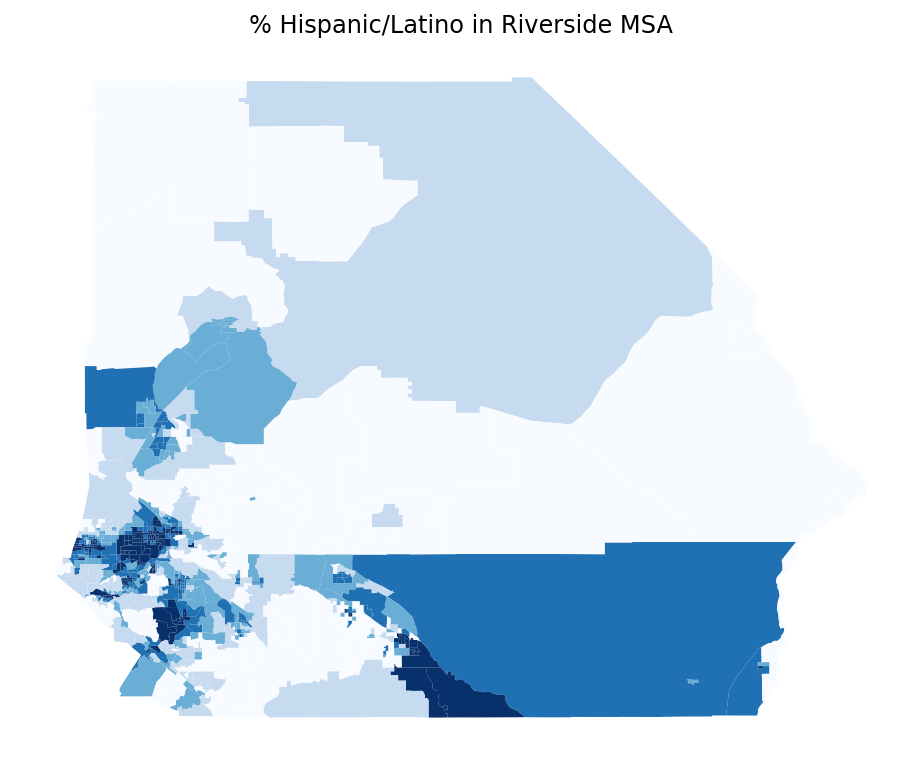

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
rside.plot('p_hispanic_persons', scheme='quantiles', cmap='Blues', ax=ax)
ax.axis('off')
ax.set_title('% Hispanic/Latino in Riverside MSA')

## Single-Value Inference

In many contexts, researchers are interested in whether some measured level of segregation is statistically different from a random process. That is, is the level of segregation we observe in place X greater than we would expect if there were no segregation at all?

For single value inference, the segregation package tests whether the observed segregation index differs from the expected value of a segregation index under the null hypothesis of no segregation. As [Boisso et al](http://dx.doi.org/10.1016/0304-4076(94)90082-5) show, the expected value of "no segregation" is not necessarily and index value of 0. The `SingleValueTest` class offers computational inference via a variety of methods for simulating observations under different randomization schemes (See notebook 05_simulating_random_population for more information about the randomization methods and how they differ)

### Evenness

In [5]:
D_rside = singlegroup.Dissim(rside, group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop')
D_rside.statistic

0.3703533440946156

The dissimilarity statistic for riverside 2010 is 0.370

The dissimilarity index is a [measure of evenness](https://www.jstor.org/stable/2579183?seq=1#metadata_info_tab_contents), so it is reasonable to use the `evenness` null approach in the `SingleValueTest` class. For more information on the different randomization procedures used in the single value test, have a look at the 05_simulating_random_population notebook

In [6]:
rside_test = inference.SingleValueTest(D_rside, null_approach='evenness')

In [7]:
rside_test.p_value

0.0

The p-value for the test is essentially 0. The `plot` method of the class will show the simulated null distribution in blue as well as the observed value for the segregation statistic in red

<AxesSubplot:title={'center':'Dissim (Value = 0.37)'}, ylabel='Count'>

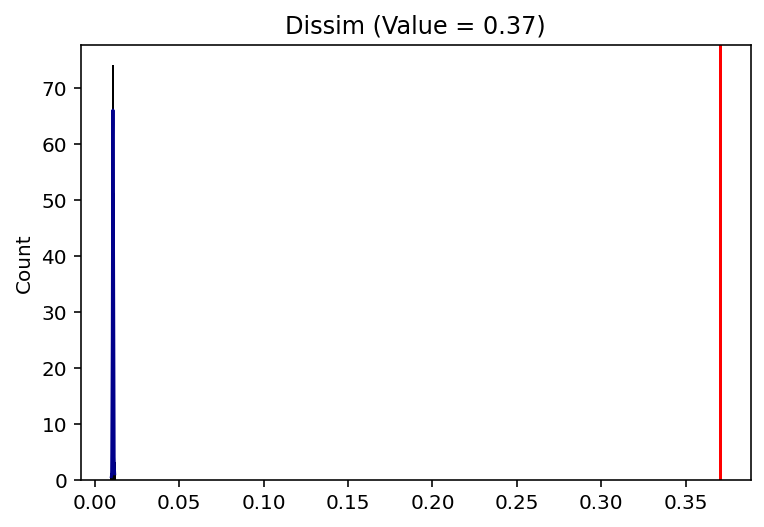

In [8]:
rside_test.plot()

In [9]:
rside_test.est_sim.mean()

0.010840651992003129

The `est_sim` attribute on the SingleValueTest class contains the segregation index values calculated for the synthetic datasets. Here we can see the estimated Dissimilarity index under the assumption of perfect evenness in Riverside is 0.011

Here the plot shows that if Riverside's population were perfectly even across geographic units, the unequal levels in population groups would still result in a small level of Dissimilarity segregation (just barely above 0). But the distribution is nonetheless tightly distributed around that barely-zero level, whereas observed Dissimilarity in Riverside is 0.37 so we reject the null of "no segregation" in favor of the hypothesis that the Hispanic/Latino population in Riverside is significantly segregated.

### Bootstrap

As an alternative to simulating a null distribution, another resonable test for the Dissimilarity index is a bootstrap approach, used to simulate the distribution of the Dissimilarity index itself, then a given value for "no segregation" can be tested against this reference distribution. In practical terms, that means the bootstrapped index value can be tested against 0, or against the value given by a null distribution such as evenness above

In [10]:
# standard test against D==0

rside_test_bootstrap = inference.SingleValueTest(D_rside, null_approach='bootstrap')

<AxesSubplot:title={'center':'Dissim (Value = 0)'}, ylabel='Count'>

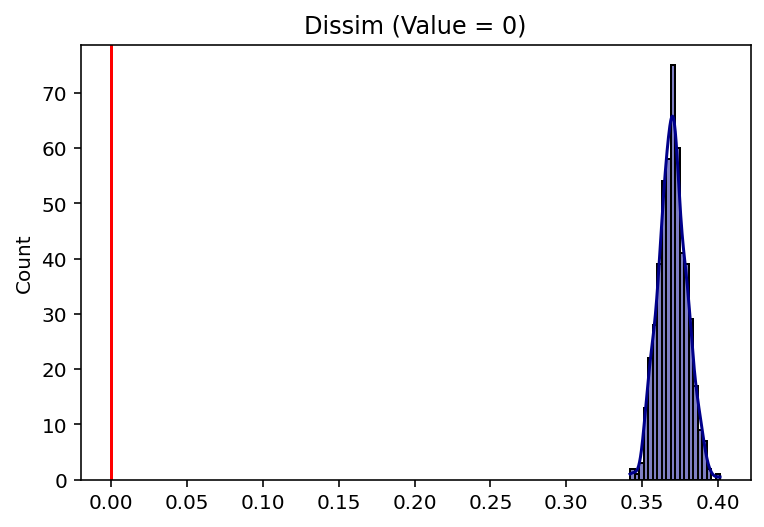

In [11]:
rside_test_bootstrap.plot()

Plotting a `SingleValueTest` with the bootstrap method now shows the bootstrapped distribution of the segregation index versus the point estimate of no segregation (rather than the point estimate of the segregation index versus the simulated null distribution in the evenness approach above)

In [12]:
# test against the value 0.010819964855634098 estimated above

rside_test_bootstrap2 = inference.SingleValueTest(D_rside, null_approach='bootstrap', null_value=rside_test.est_sim.mean())

<AxesSubplot:title={'center':'Dissim (Value = 0.011)'}, ylabel='Count'>

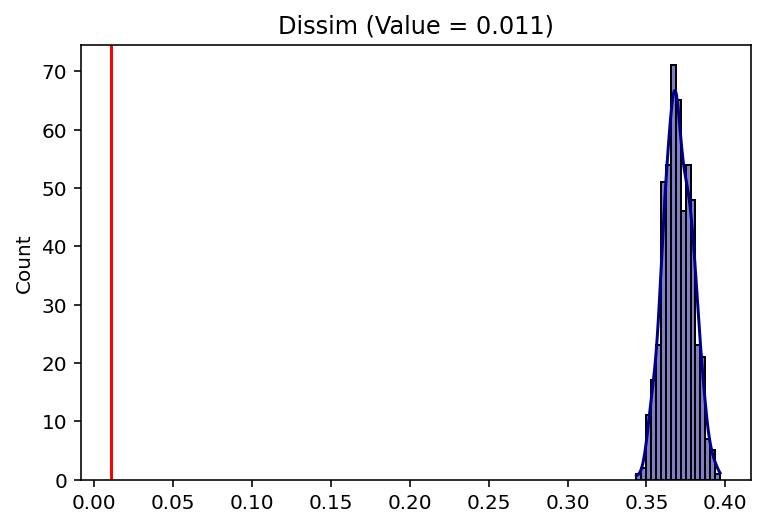

In [13]:
rside_test_bootstrap2.plot()

Whether we test against 0 or the simulated value from evenness, our inference is the same: we reject the null; Riverside is clearly segregated according to this test

### Random Geographic Permutation

Alternatively, we might have examined a different segregation index, such as the Relative Concentration index, a spatial measure for which a different test would be appropriate

The random geographic permutation test shuffles the values of tracts in space to create a spatially-random distribution. This test leaves the total population in each group of each geographic unit, but randomizes where the unit exists in space

In [14]:
# for spatial analysis, we need to sure rside data is in the correct projection
rside = rside.to_crs(rside.estimate_utm_crs())

In [15]:
RCO_rside = singlegroup.RelativeConcentration(rside, group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop')

In [16]:
RCO_rside.statistic

0.47950515318312203

In [17]:
rside_test_permutation = inference.SingleValueTest(RCO_rside, null_approach='geographic_permutation')

In [18]:
rside_test_permutation.p_value

0.016

<AxesSubplot:title={'center':'RelativeConcentration (Value = 0.48)'}, ylabel='Count'>

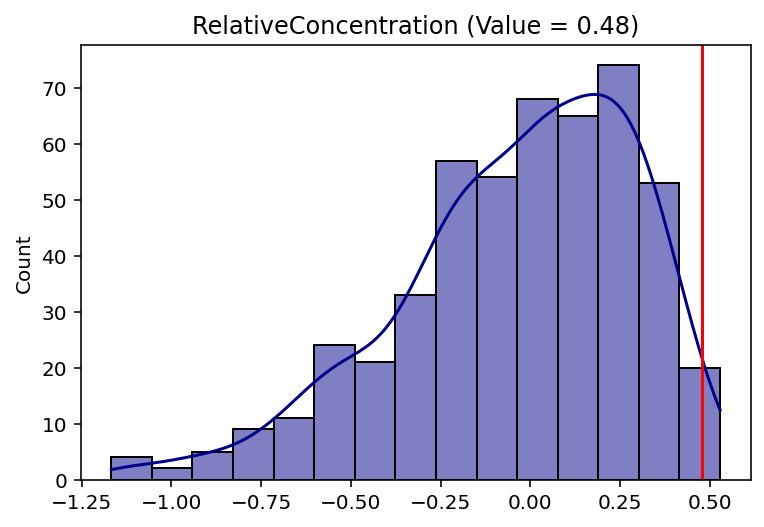

In [19]:
rside_test_permutation.plot()

### Evenness Geographic Permutation

It is also possible to combine the two previous approaches to first generate a simulated population under the assumption of evenness, *then* geographically permute the simulated data

In [20]:
rside_test_evenpermutation = inference.SingleValueTest(RCO_rside, null_approach='even_permutation')

<AxesSubplot:title={'center':'RelativeConcentration (Value = 0.48)'}, ylabel='Count'>

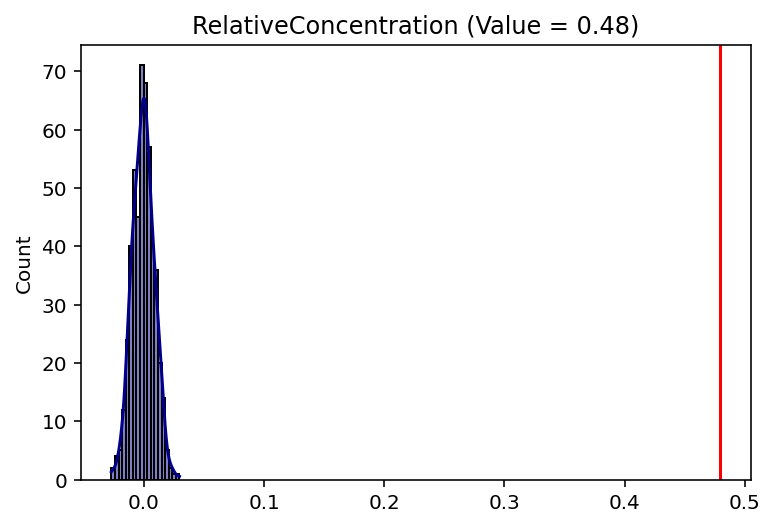

In [21]:
rside_test_evenpermutation.plot()

Here the inference becomes even stronger that we reject the null

## Comparative Inference

Comparative inference is particularly useful in studying residential segregation because it facilitates both temporal and spatial comparisons, allowing researchers to ask whether one place is more segregated than another, or whether a given place has become more/less segregated over time.

As with single-value inference, the `TwoValueTest` class offers several techniques for conducting the analysis

In [22]:
# los angeles MSA in 2010
la = Community.from_census(years=[2010], msa_fips='31080').gdf

In [23]:
# los angeles in 1990
la90 = Community.from_census(years=[1990], msa_fips='31080').gdf

SubplotsContainer([CartesianAxesSubplot(0.0532013,0.236122;0.340307x0.720046), CartesianAxesSubplot(0.651196,0.236122;0.340287x0.720046)])

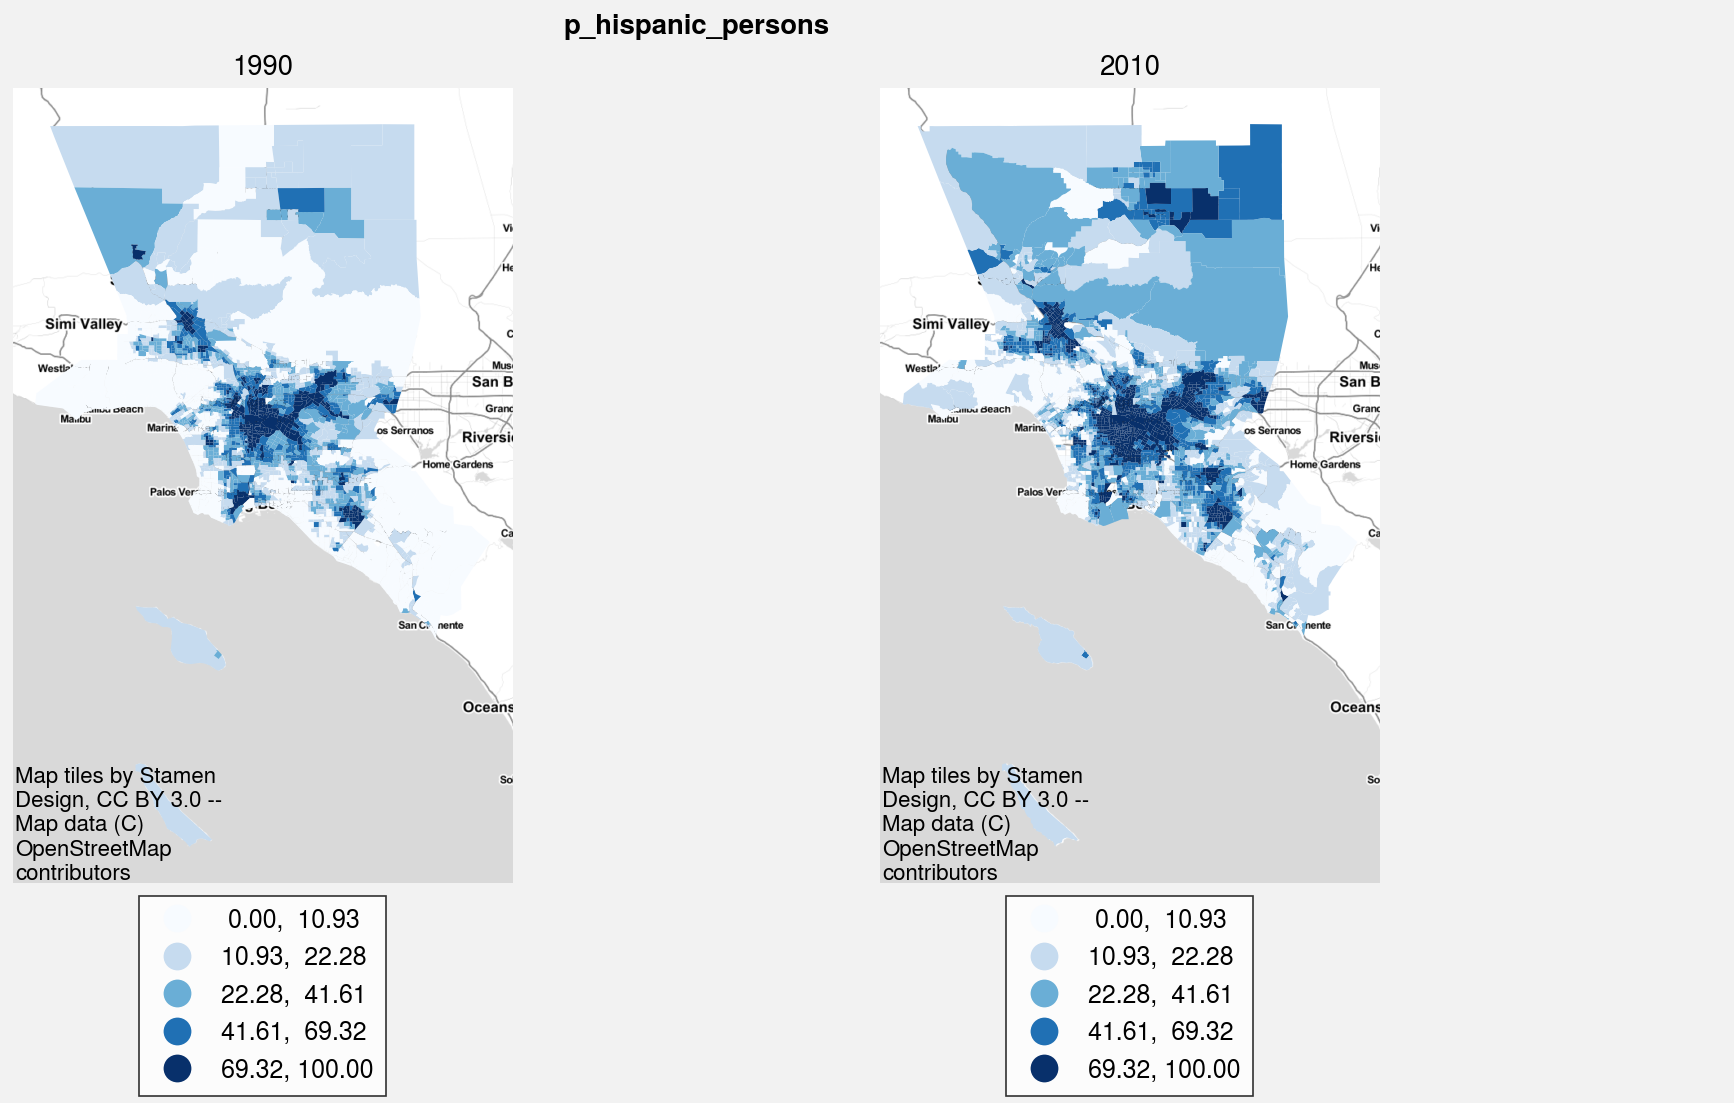

In [24]:
p = Community.from_geodataframes([la, la90])
p.plot_timeseries('p_hispanic_persons', scheme='quantiles', cmap='blues')

In [25]:
D_la = singlegroup.Dissim(la, group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop')
D_la.statistic

0.5180472134918201

The dissimilarity statistic for LA 2010 is 0.518

In [26]:
D_la90 = singlegroup.Dissim(la90, group_pop_var='n_hispanic_persons', total_pop_var='n_total_pop')
D_la90.statistic

0.507180915697462

The dissimilarity statistic for LA 1990 is 0.507  

So in 20 years, Hispanic/Latino segregation in LA has increased from 0.507 to 0.518. Is that increase singnificantly different than might occur at random?

Again, there are several methods available for testing differences between segregation values. Random labelling, based on [Rey and Guitierrez](http://www.tandfonline.com/doi/abs/10.1080/17421772.2010.493955) creates a set of synthetic observations by shuffling geographic units between the two cities, calculating segregation statistics on these synthetic datasets, then taking the difference between the statistics. This process results in a distribution of differences (under the null that there is no difference between the cities), and we test the observed difference against this distribution

### Random Labeling

In [27]:
la_test_label = inference.TwoValueTest(D_la, D_la90, null_approach='random_label')

In [28]:
la_test_label.p_value

0.216

There's a 21.2% chance of obtaining these results at random, so we fail to reject the null hypothesis that segregation has increased significantly

<AxesSubplot:title={'center':'Dissim (Diff. value = 0.011)'}, ylabel='Count'>

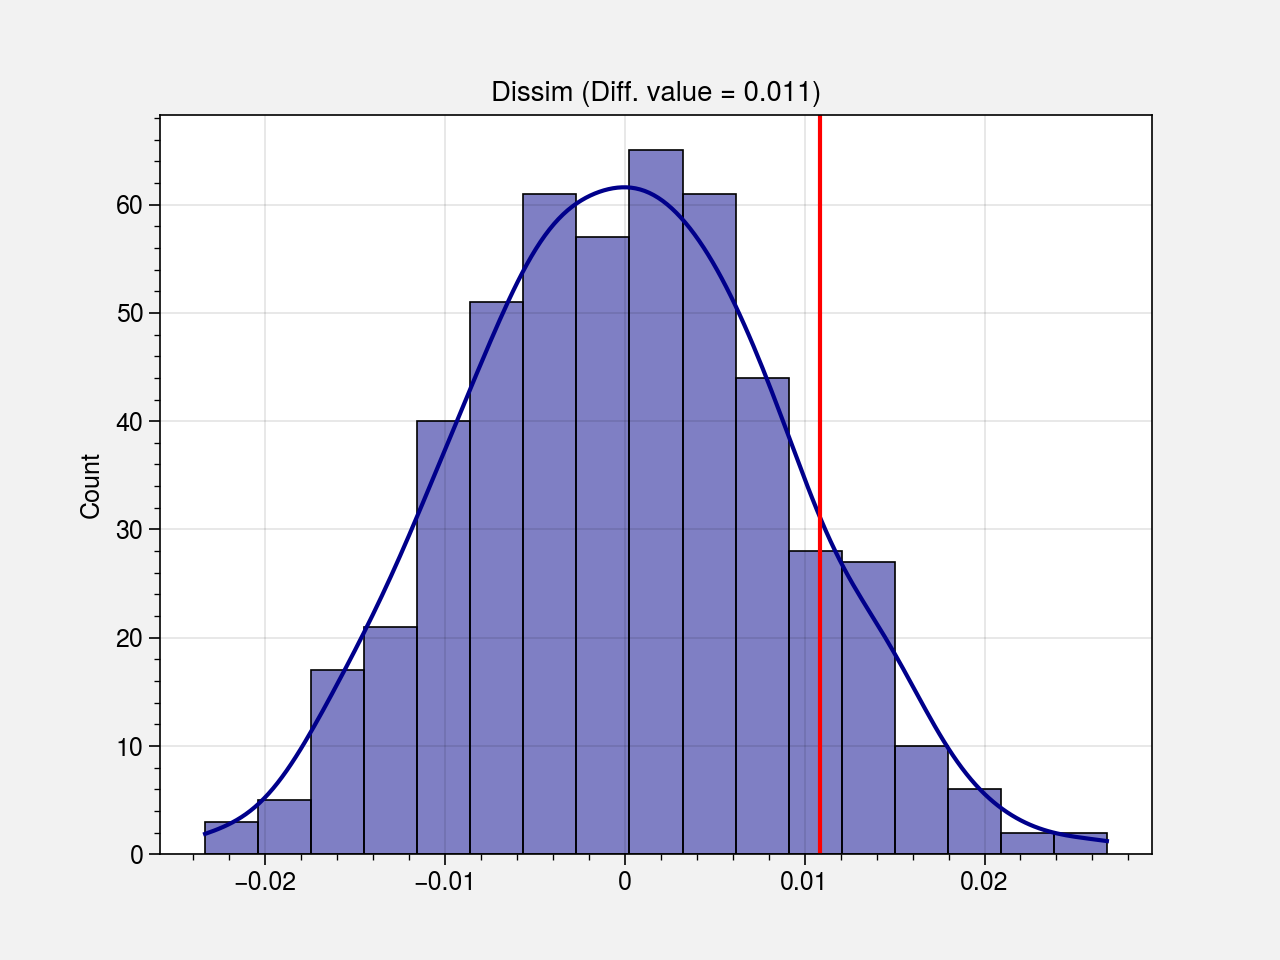

In [29]:
la_test_label.plot()

Plotting the class shows the distribution of simulated differences in blue as well as the estimated difference in red. Here it is clear that the observed difference falls well within the distribution

#### LA vs Riverside

In [30]:
la_rside_test_label = inference.TwoValueTest(D_rside, D_la, null_approach='random_label')

<AxesSubplot:title={'center':'Dissim (Diff. value = -0.148)'}, ylabel='Count'>

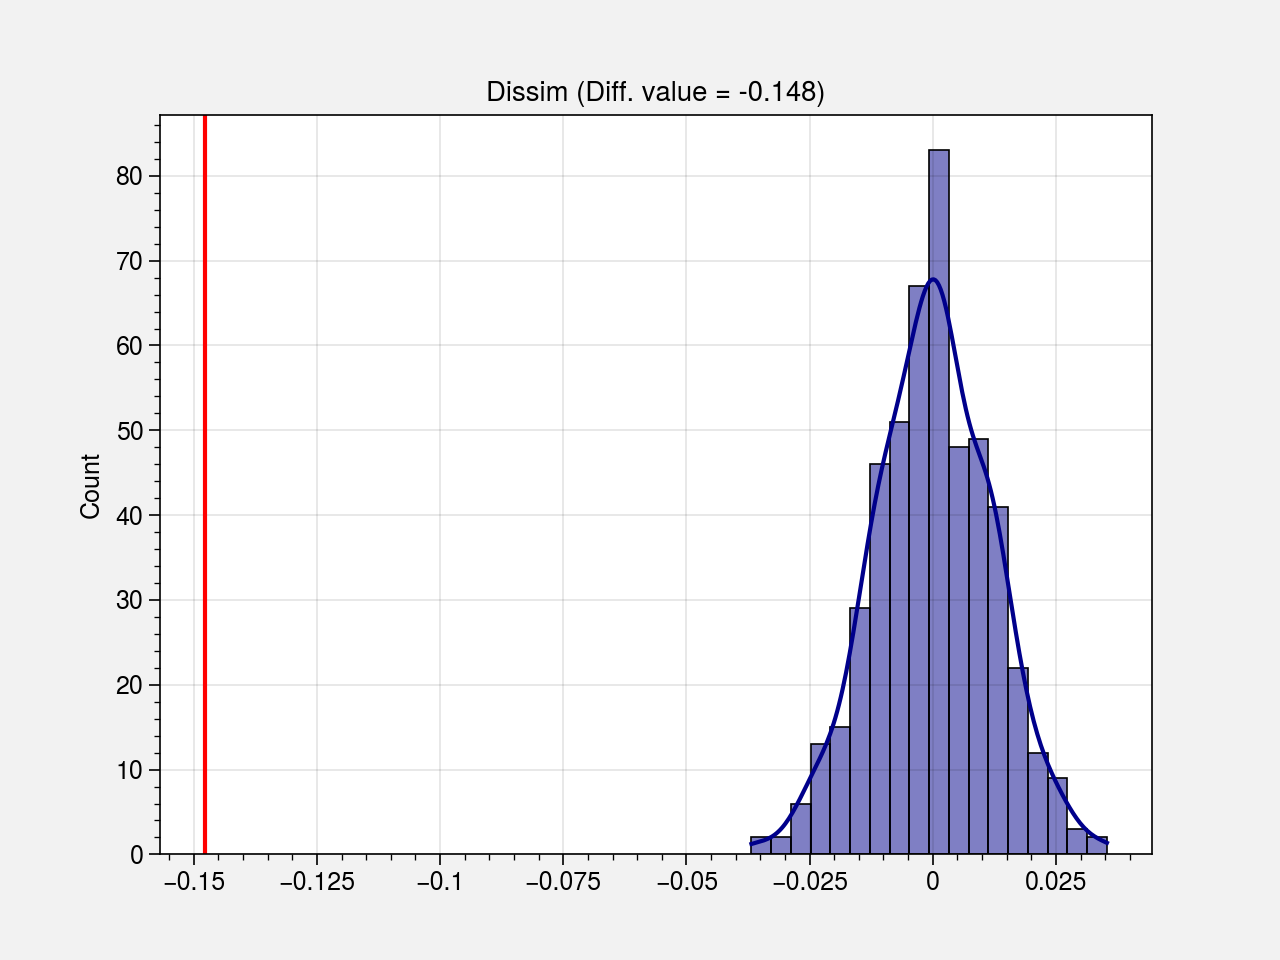

In [31]:
la_rside_test_label.plot()

The results show that LA is significantly more segregated than Riverside, but LA is not significantly more segregated in 2010 than it was in 1990

### Bootstrap

The bootstrap test based on [Davidson 2009](http://dx.doi.org/10.1016/j.jeconom.2008.11.004) uses the bootstrap resampling technique to estimate a distribution of the segregation index for each city, which provides an estimate of each index's variance. Following, we perform a means test to see whether the mean of each distribution is significantly different from one another

#### LA over time

In [32]:
la_test_bootstrap = inference.TwoValueTest(D_la, D_la90, null_approach='bootstrap')

In [33]:
la_test_bootstrap.p_value

0.2339804424902052

<AxesSubplot:title={'center':'Dissim (Diff. value = 0.011)'}, ylabel='Count'>

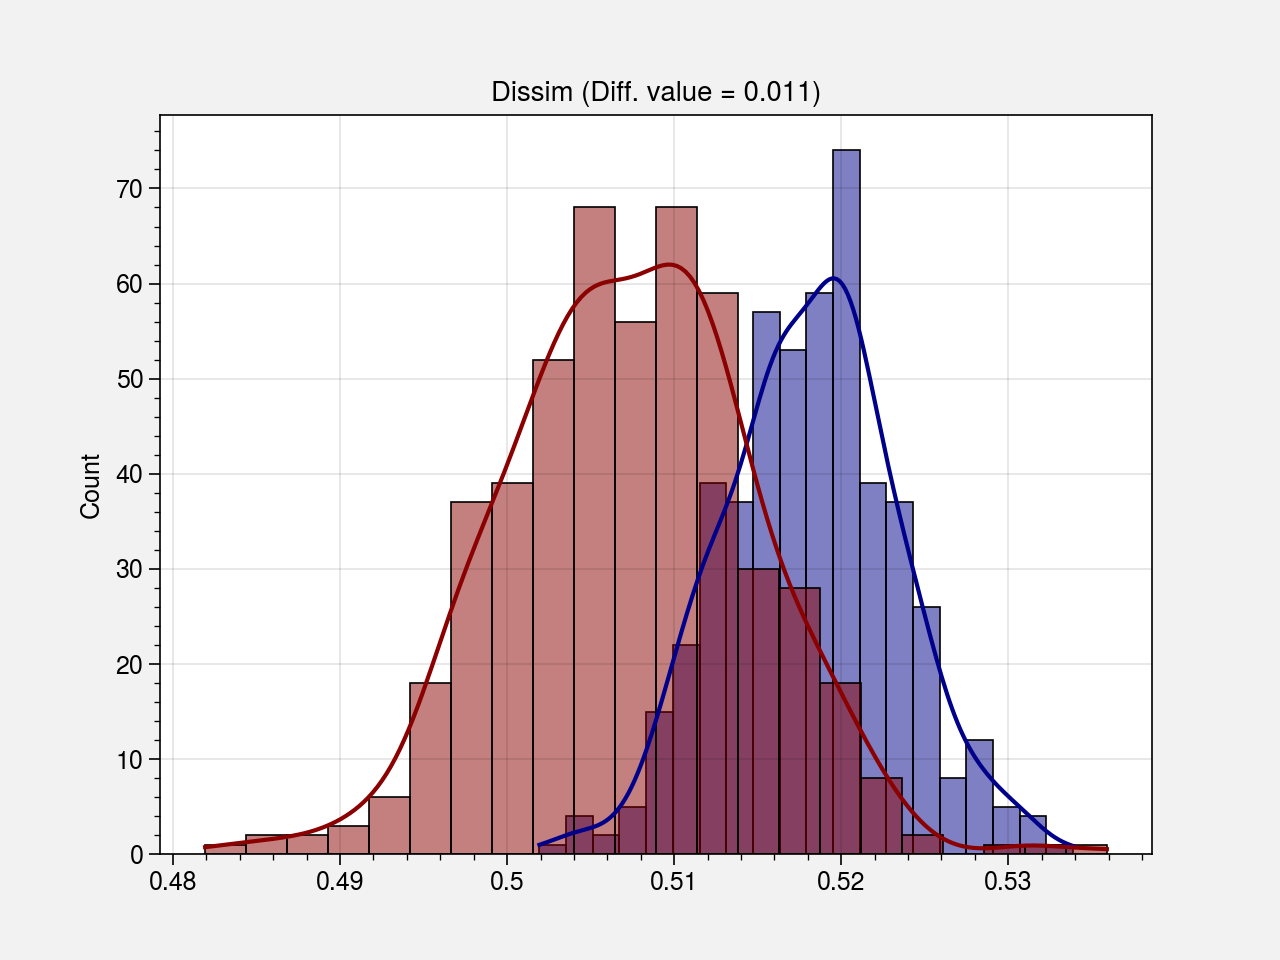

In [34]:
la_test_bootstrap.plot()

Plotting a TwoValueTest class with the bootstrap method shows the bootstrapped distributions for both segregation indices. Here we can clearly see that the distributions overlap substantially

#### LA vs Riverside

In [35]:
la_rside_test_bootstrap = inference.TwoValueTest(D_rside, D_la, null_approach='bootstrap')

In [36]:
la_rside_test_bootstrap.p_value

2.1307916508767897e-38

The test is highly significant

<AxesSubplot:title={'center':'Dissim (Diff. value = -0.148)'}, ylabel='Count'>

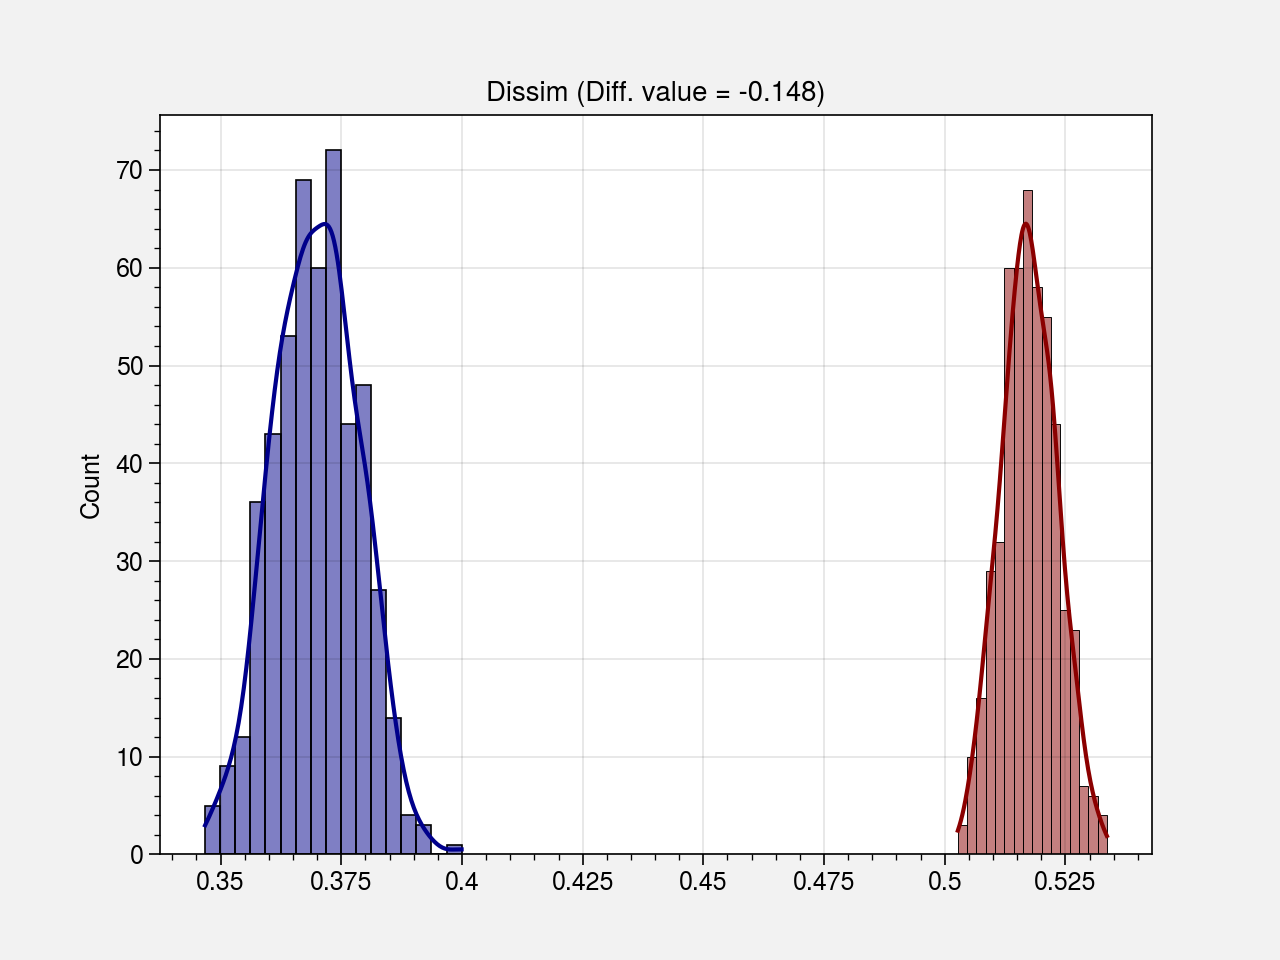

In [37]:
la_rside_test_bootstrap.plot()

Again, the results show a significant difference between Riverside and LA, but not LA over time

**Note**: The bootstrap test is only appropriate for aspatial segregation indices, first because simple bootstrap techniques do not account for spatial autocorrelation, and second because bootstrapping spatial units results in synthetic regions that have duplicate units (and thus the data are not planar enforced, so a spatial index cannot be computed)

For comparative inference, there are also additional randomization approaches based on counterfactual population generation described in the 07_decomposition notebook